### 3.1 Simple Robbins Monro

Write the first order budget constraint as :$$F(w) = E[(R-\mu)(R-\mu)']w + \lambda \mathbf{1}_n = Sw + \lambda \mathbf{1}_n=0,$$ 
We can write $F(w) = E(f(w, R)),$ where $$f(w,R) = (R-\mu)(R-\mu)'w + \lambda\mathbf{1}_n$$
We can easily verify the 2 assumptions: 

* if $w*$ is the solution, $\forall w\in \mathbb{R}^n$,
\begin{eqnarray}
 \langle w - w*, F(w)\rangle &=& \langle w-w*, Sw + \lambda \mathbf{1}_n\rangle \\
 &=& \langle w-w*, S(w-w*) + Sw*+ \lambda \mathbf{1}_n\rangle \\
 &=&\langle w-w*, S(w-w*)\rangle >0
\end{eqnarray}


* $\forall w\in \mathbb{R}^n, E(f^2(w, R)) = E(w^TA^2w+2w^TA\cdot\lambda\mathbf{1}_n+n\lambda^2\leq C(1+|w|^2),$where$A = (R-\mu)(R-\mu)',$ when $C$ is quite large. 

In [1]:
import numpy as np
import scipy 
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm,trange

In [2]:
n = 3
mu = np.array([.05, .07, .06])  # R~ N(mu, S)
D = np.diag([.1, .14, .2])      # S = DKD
rho = 0.5
K = np.array([[1, rho, 0],
             [rho, 1, rho],
             [0, rho, 1]])
lambd = 0.3
S = np.matmul(np.matmul(D, K), D)

In [3]:
def f(w, R, lambd = lambd):
    """
    function for Robbins Monro regression
        E[f(w,R)] = F(w) = 0 
    
    inputs :
            w :   w_n-1 in the regression
            R :   A random vector to perform the RM
        lambd :   eigenvalue default by 0.3
    return : f(w,R)
    """
    t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
    t2 = mu.reshape(n, 1)
    return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

In [4]:
def plot_trace(h):
    l = np.shape(h)[0]
    hh = np.array(h)
    plt.plot(hh[:l,0])
    plt.ylim(-1.,1.)
    plt.show()
def theory_answer(S):
    inv = np.linalg.inv(S)
    w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
    return w

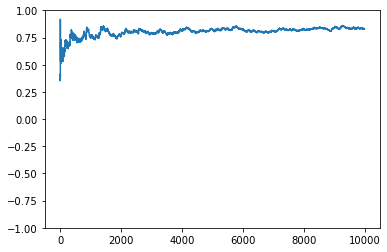

final result is 
 [[ 0.83050365]
 [-0.04220531]
 [ 0.21170166]]
compare with the theory result 
 [[ 0.82688391]
 [-0.0407332 ]
 [ 0.21384929]]


In [5]:
def Robbins_Monro_Regression(N = 10000, alpha = 0.6):
    R = np.random.multivariate_normal(mu, S, N)
    x = np.random.random(n)
    x = x/np.sum(x)
    w = [x.reshape(n,1)]     # initialization with equal value
    w_hist = [x.reshape(n,1)]
    rg = range(N)
    if N > 1e4 :
        rg = tqdm(rg)
    for i in rg:
        w_tmp = w[-1] - 10.*f(w[-1], R[i])/np.power(i+1,alpha)
        w.append(w_tmp)
        w_hist.append(w_tmp/np.sum(w_tmp))
    plot_trace(w_hist)
    print("final result is \n {}".format(w[-1]/np.sum(w[-1])))
    print("compare with the theory result \n {}".format(theory_answer(S)))
    return w[-1]/np.sum(w[-1]),w,w_hist
x,_,_ = Robbins_Monro_Regression(N = 10000,alpha = 0.6)

## 3.2

In [6]:
def S_rho(rho):
    D = np.diag([.1, .14, .2])
    # rho = 0.5
    K = np.array([[1, rho, 0],
                 [rho, 1, rho],
                 [0, rho, 1]])
    S = np.matmul(np.matmul(D, K), D)
    return S

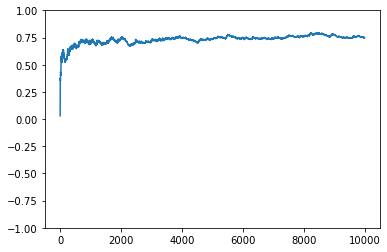

final result is 
 [[0.74714396]
 [0.10139851]
 [0.15145752]]
compare with the theory result 
 [[0.73492551]
 [0.09458501]
 [0.17048948]]


In [7]:
S = S_rho(rho=0.4)
_,_,_ = Robbins_Monro_Regression(alpha=0.6)

In [8]:
def UQSA_adapted(rho_min, rho_max, u0 = '', K = 1000, n = 3, a = 0.875, b = 0.3):   # mk
    m = [int(np.floor(np.power(k, b))) + 1 for k in range(K+1)]   #   mk[0] = 1
    if u0=='' : 
        u0 = np.random.randn(m[0] + 1, n)   

    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([rho_min, rho_max])) for i in range(np.max(m)+1)]   
        
    def W(m_k, rho, u0, Legendre_basis = B):
        return np.sum([u0[j]*Legendre_basis[j](rho) for j in range(m_k+1)], axis = 0)
#     trace = []
    for k in tqdm(range(1, K+1)):

        r = np.random.uniform(low = rho_min, high = rho_max)
        S = S_rho(r)
        R = np.random.multivariate_normal(mu, S)
        
        u = np.zeros((m[k] + 1, n))
        for i in range(m[k] + 1):
            w = W(m[k-1], r, u0)
#             trace.append(w[0])
            expect = (B[i](r) * f(w.reshape(n,1), R)).reshape(n)
            
            gamma = 1./np.power(k, a) #stepsize
            
            if i > m[k-1]:
                u[i] = - gamma * expect
            else:
                u[i] = u0[i] - gamma * expect
            
            u0 = u
    return u

In [9]:
def result_UQSA_adapted(r,K=1000):
    u = UQSA_adapted(0.3,0.5,K=K)
#     print(u)
    rg = range(int(np.floor(np.power(K, 0.3))) + 1 )
    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([0.6, 0.8])) for i in rg]
    result = np.zeros(3)
    
    for j in rg:
        result = result + B[j](r)*u[j]
#     plt.plot(trace)
    return result/np.sum(result)

In [10]:
result_UQSA_adapted(0.4, 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 967.36it/s]


array([0.35458653, 0.35247175, 0.29294172])

### 5. 1 Function choice
Now we try to tune the problem into a equivalent problem:
$$min_{x\in\mathbb{R}^{d-1}}\frac{1}{2}w(x)^TSw(x),$$
where $w(x)=(x_1, x_2, ... x_{d-1}, 1-\sum_i^{d-1}x_i)^T$

Taking the partial derivative:
$$\partial_{w_i}(\frac{1}{2}w(x)^T)Sw(x)) = (Sw(x))_i - (Sw(x))_d,\quad i=1,\, 2,\, \cdots,\, d-1$$
where $Sw(x)_i$ is the i-th row of the vector $Sw.$

We take $$F^r(w) = \{(Sw(x))_i - Sw(x)_d\}_{i=1}^{d-1}$$
Now we verify the condition $\langle F^r(x), x-x^*\rangle>0, \forall x\neq x^*, x\in \mathbb{R}^{d-1}$.

Firstly $$w(x)=(x_1, x_2, ... x_{d-1}, 1-\sum_i^{d-1}x_i)^T = Ax+b,$$
where
$$
A 
= 
\begin{pmatrix} 
1 & 0 & \cdots & 0\\
0 & 1 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & \cdots & 0 & 1 \\
-1 & -1 & \cdots & -1
\end{pmatrix}_{d\times(d-1)},
b = (0,\, 0,\,\cdots,0,\,1)^T\in \mathbb{R}^{d}
$$
We can also write the vector $F(w)$ as 
$$
F^r(w)
=
\begin{pmatrix} 
(Sw)_1 - (Sw)_d \\
(Sw)_2 - (Sw)_d\\
\vdots \\
(Sw)_{d-1} - (Sw)_d
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & \cdots & 0 & -1 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & 1 & -1
\end{pmatrix}_{(d-1)\times d}
=
A^TSw.
$$
Hence we have $$F^r(w(x))=A^TSw = A^TS(Ax+b) = Cx + c,$$
where $C = A^TSA\in \mathcal{M}_{d-1}, \, c = A^TSb\in \mathbb{R}^{d-1}.$

So we have $\forall x \in \mathbb{R}^{d-1}, x\neq x^*$, where $F^r(w(x^*)) = Cx^*+c=0$,
$$\langle Cx+c,\, x-x^*\rangle= \langle C(x-x^*)+Cx^*+c,\, x-x^*\rangle = \langle C(x-x^*),\, x-x^*\rangle>0,$$
since $C$ is positive definite.

Note that the second condition of the Robinson-Monro is obviously satisfied.

Now we take $F^r(w(x)) = E(f^r(w(x), R)),$ where $$f(w(x),R) = A^T(R-\mu)(R-\mu)'w(x) = A^T(R-\mu)(R-\mu)'(Ax+b),$$
we are going to implement the Robbins-Monro and the UQSA with this new function.

#### Robbins-Monro

In [6]:
n = 3
unit = np.identity(n-1)
ones = np.ones((1, n-1))
A = np.vstack((unit, -ones))
b = np.vstack((np.zeros((n-1,1)), [[1]]))
A, b

(array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -1.]]),
 array([[0.],
        [0.],
        [1.]]))

In [12]:
def f2(x, R):
    """
    function for Robbins Monro regression
        E[f2(w(x),R)] = F^r(w(x)) = 0 
        Note that A is of dim (d,d-1) (d = n = len(R_))
    inputs :
            x :   n-1 vector in the regression
            R :   A random vector to perform the RM
            
    return : f(w,R) of dimension n-1
    """
    x_, R_, mu_ = x.reshape(n-1,1), R.reshape(n, 1), mu.reshape(n, 1)
    
    left = np.matmul(A.T, np.matmul(R_ - mu_, (R_ - mu_).T))
    right = np.matmul(A, x) + b
    
    result = np.matmul(left, right)
    
    return result
    

In [2]:
def RM_bis(N = 10000, alpha = 0.6):
    R = np.random.multivariate_normal(mu, S, N)
    x = np.random.random((n - 1, 1)) # initialization with random value
    
    w0 = np.vstack((x, 1 - np.sum(x)))
    w = [w0]
    w_hist = [w0.reshape(n, 1)]
    
    rg = range(N)
    if N > 1e4 :
        rg = tqdm(rg)
        
    for i in rg:
        x = x - 10.*f2(x, R[i])/np.power(i+1, alpha)
        w_tmp = np.vstack((x, 1 - np.sum(x)))
        w.append(w_tmp)
        w_hist.append(w_tmp/np.sum(w_tmp))
        
    plot_trace(w_hist)
    
    print("final result is \n {}".format(w[-1]/np.sum(w[-1])))
    print("compare with the theory result \n {}".format(theory_answer(S)))
    return w[-1]/np.sum(w[-1]),w,w_hist
x,_,_ = RM_bis(N = 10000,alpha = 0.65)

NameError: name 'mu' is not defined

# MARK

In [15]:
class UQSA_generator:
    def __init__(self,K, n = 3, n_iter = 3, r_min = 0.3, r_max = 0.5, gamma = None,m = None,M = None,a = None,b=None,plot = False):
        self.K = K
        if gamma is not None:
            self.gamma = gamma
        elif b is not None:
            self.gamma = [1./np.power(k,b) for k in range(K+1)]
        else:
            self.gamma = [1./np.power(k,0.65) for k in range(K+1)]
            
        if not a:
            a = 0.24
        self.m = [int(np.floor(np.power(k, a))) + 1 for k in range(K+1)]
        
        if M is None:
            self.M = [10]*(K+1)
        else:
            self.M = M
            
        self.u0 = None
        self.u_record = None
        self.r_min = r_min
        self.r_max = r_max
        self.n = n                # n is the dimension of w and theoretically
        self.n_iter = n_iter      # n_iter is the dimension of MC iteration for exemple if we take w_{n} = 1 - sum_1^{n-1}(w_{i}), then n_iter = n-1
        self.mu = np.array([.05, .07, .06])  # TODO
#         self.LB = [np.sqrt((2*i+1)/(self.r_max-self.r_min))*np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([r_min, r_max])) for i in range(np.max(self.m)+1)]
        self.LB = None            #our reduced Legendre basis is then constructed by self function Legendre_B()
        self.plot = plot          #Flag for plot
#     def f(self, w, R, lambd = 0.3):
#         """
#         function for Robbins Monro regression
#             E[f(w,R)] = F(w) = 0 

#         inputs :
#                 w :   w_n-1 in the regression
#                 R :   A random vector to perform the RM
#             lambd :   eigenvalue default by 0.3
#         return : f(w,R)
#         """
#         t1 = R.reshape(self.n, 1)   # reshape R^n vectors into col-vectors
#         t2 = mu.reshape(self.n, 1)
#         return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((self.n, 1))

    def Legendre_B(self,a, b, n):
        """
        generate a normalized Legendre basis in the interval [a, b]
        n is the number of the Legendre basis needed
        """
        delta = b-a
        LB = [np.sqrt((2*i+1)/delta)*np.polynomial.legendre.Legendre.basis(deg=i) for i in range(n)]
        new = []
        for i in range(n):
            z = lambda x, i=i: LB[i]((2*x-a-b)/(b-a))
            new.append(z)
        return new
    
    def f(self, x, R):
        """
        function for Robbins Monro regression
            E[f2(w(x),R)] = F^r(w(x)) = 0 
            Note that A is of dim (d,d-1) (d = n = len(R_)) (n,n_iter = n - 1)
        inputs :
                x :   n-1 vector in the regression
                R :   A random vector to perform the RM

        return : f(w,R) of dimension n-1
        """       
        A,b,n,n_iter = self.A, self.b, self.n, self.n_iter
        x_, R_, mu_ = x.reshape(n_iter,1), R.reshape(n, 1), self.mu.reshape(n, 1)

        left = np.matmul(A.T, np.matmul(R_ - mu_, (R_ - mu_).T))
        right = np.matmul(A, x) + b

        result = np.matmul(left, right)

        return result
    def W(self,m_k, rho, u0):
        return np.sum([u0[j]*self.LB[j](rho) for j in range(m_k+1)], axis = 0)
    
    def S_rho(self, rho):
        D = np.diag([.1, .14, .2])
        # rho = 0.5
        K = np.array([[1, rho, 0],
                     [rho, 1, rho],
                     [0, rho, 1]])
        S = np.matmul(np.matmul(D, K), D)
        return S
    
    def omega_theory(self,r):
        n = self.n
        S = self.S_rho(r)
        inv = np.linalg.inv(S)
        w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
        return w
    
    def u0_initialization(self):
        n = self.n_iter #attention!!!
        unit = np.identity(n)
        ones = np.ones((1, n))
        self.A = np.vstack((unit, -ones))
        self.b = np.vstack((np.zeros((n,1)), [[1]]))
        
        ##########################
        ####  trich init   #######
        ##########################
        res = []
        for i in range(np.max(self.m)+1):
            res_i = []
            for j in range(n):
                func = lambda r: self.omega_theory(r)[j] * self.LB[i](r)    
                res_i.append(quad(func,self.r_min,self.r_max)[0]) #integral w()*B_i() \pi(d\rho) \pi(0.2) = 1
            res.append(res_i)
        self.u_theory_result = res
#         self.u0 = res
        ###########################
#                   MC
        ###########################
        u0_init = []
        rss = np.linspace(self.r_min,self.r_max,101)
        for i in range(np.max(self.m) + 1):
            u0_init_i = []
            for j in range(n):
                summ = 0.0
                for r in rss:
                    summ += self.omega_theory(r)[j] * self.LB[i](r)*1e-2 *0.2 
                u0_init_i.append(summ[0])  #MC Expectation = \int w(r)B_i(r) \pi(d\theta) et \pi(d\theta) = 0.2*d\theta in this case
            u0_init.append(u0_init_i)
            
        self.u_record = [u0_init]
        self.u0 = u0_init
        return self.u_theory_result
        
    
    def iteration(self):
        u0 = np.array(self.u0)
#         u0 = np.random.randn(np.shape(u0)[0],np.shape(u0)[1])
        n = self.n_iter
        for k in trange(1, self.K+1):
            rho = []
            R = []
            u = np.zeros((self.m[k] + 1, n))
            
            for s in range(self.M[k]+1):
                r = np.random.uniform(low = self.r_min, high = self.r_max)
                rho.append(r)
                S = self.S_rho(r)
                R.append(np.random.multivariate_normal(self.mu, S))
                
            for i in range(self.m[k] + 1):
                expect = 0.0
                for s in range(1,self.M[k]+1): 
                    w = self.W(self.m[k-1], rho[s], u0)
                    expect += (self.LB[i](rho[s]) * self.f(w.reshape(n,1), R[s])).reshape(1,n)
                expect /= self.M[k]
                if i > self.m[k-1]:
                    u[i] = - self.gamma[k] * expect
                else:
                    u[i] = u0[i] - self.gamma[k] * expect
            u0 = u
            self.u_record.append(u)
        return u
    def run_out(self, rs = None):
        self.LB = self.Legendre_B(self.r_min,self.r_max,np.max(self.m)+1)

        if rs is None:
            rs = [0.5*(self.r_min + self.r_max)]
        self.u0_initialization()

        res = self.iteration()
#         print("the u in the end of the iteration is : \n{}".format(res))
        
        for r in rs:
            x = self.W(np.max(self.m),r,res)
            calcul_answer = list(x)
            calcul_answer.append(1-sum(x))
#             print("-"*60)
#             print("and the result of rho = {} is \n {}".format(r,calcul_answer))
#             print("compare with the theory result : \n {}\n".format(self.omega_theory(r).reshape(1,self.n)))
        res = []
        for i in range(50,self.K,5):
            res.append(self.u_record[i][2][1])
        if self.plot:
            eapp = []
            u = self.u_theory_result
            u_record = self.u_record
            rhos = np.random.rand(100) * 0.2 + 0.3
            etot = []
            
            def dist(x,y):
                return sum([(x[i]-y[i])**2 for i in range(len(x))])
            for u_t in u_record:
                eapp.append(sum([dist(u_t[i],u[i]) for i in range(len(u_t))]))

            w = self.omega_theory
            for i in range(50,self.K,50):
                temp = 0.0
                for rho in rhos:
                    w_UQSA = list(uqsa.W(len(u_record[i])-1,rho,u_record[i]))
                    s = sum(w_UQSA)
                    w_UQSA.append(1.0-s)
            #         print((w_UQSA))

                    temp += (dist(w(rho),w_UQSA))
                etot.append(temp/500)  
#                 eapp_toplt = eapp[50:1000:50]
#                 diff = [etot[i] - eapp_toplt[i] for i in range(len(etot))]
#                 plt.plot(range(50,1000,50),etot,label = 'total error')
#                 plt.plot(range(50,1000,50),eapp_toplt, label = 'approx error')
#                 plt.legend(loc='best')
            fig ,(ax1,ax2) = plt.subplots(2)    
                
            ax1.plot(range(len(eapp)),eapp)  
            ax2.plot(range(50,self.K,50),etot,label = 'total error') 
            ax2.plot(range(50,self.K,50),eapp[50:self.K:50],label = 'approx error') 
            ax2.legend(loc='best')
            
            plt.show()
#             plt.title("error approximation")
        return res

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.32it/s]


the u in the end of the iteration is : 
[[ 0.33340345  0.0370378 ]
 [ 0.01715542 -0.02166042]
 [-0.00200049  0.00274261]
 [ 0.00311671  0.00034019]
 [-0.00217217 -0.00073593]
 [-0.00348584  0.00070611]
 [ 0.0010913   0.0007244 ]]
------------------------------------------------------------
and the result of rho = 0.3 is 
 [0.6707076320195213, 0.1740768733594983, 0.1552154946209804]
compare with the theory result : 
 [[0.67654597 0.17242183 0.1510322 ]]

------------------------------------------------------------
and the result of rho = 0.4 is 
 [0.7423002787146643, 0.07228614201932593, 0.18541357926600976]
compare with the theory result : 
 [[0.73492551 0.09458501 0.17048948]]

------------------------------------------------------------
and the result of rho = 0.5 is 
 [0.7887669007031696, 0.02079449702695582, 0.19043860226987464]
compare with the theory result : 
 [[ 0.82688391 -0.0407332   0.21384929]]



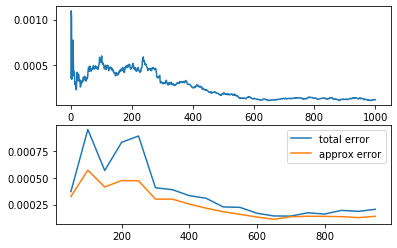

In [3]:
uqsa = UQSA_generator(n_iter=2,K=1000,plot=True)
u = uqsa.run_out([0.3,0.4,0.5])

In [4]:
u = uqsa.u_theory_result
u_record = uqsa.u_record
# w = uqsa.omega_theory

Text(0.5, 1.0, 'error approximation')

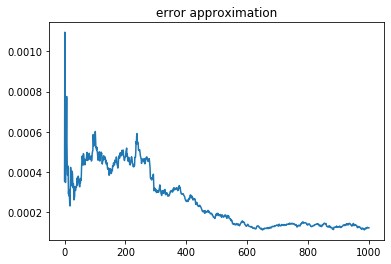

In [5]:
eapp = []
def dist(x,y):
    return sum([(x[i]-y[i])**2 for i in range(len(x))])

for u_t in u_record:
    eapp.append(sum([dist(u_t[i],u[i]) for i in range(len(u_t))]))
plt.plot(range(len(eapp)),eapp)  
plt.title("error approximation")

$$
\int_{0.3}^{0.5} B_i(\theta) B_j(\theta) d\theta = \delta_{ij}
$$
$$
\int_{0.3}^{0.5} B_i(\theta) B_j(\theta) \pi(d\theta) = 5 * \delta_{ij} = E_{\pi}[...]
$$

In [8]:
rhos = np.random.rand(100) * 0.2 + 0.3
etot = []
w = uqsa.omega_theory
for i in range(50,1000,50):
    temp = 0.0
    for rho in rhos:
        w_UQSA = list(uqsa.W(len(u_record[i])-1,rho,u_record[i]))
        s = sum(w_UQSA)
        w_UQSA.append(1.0-s)
#         print((w_UQSA))

        temp += (dist(w(rho),w_UQSA))
    etot.append(temp/500)


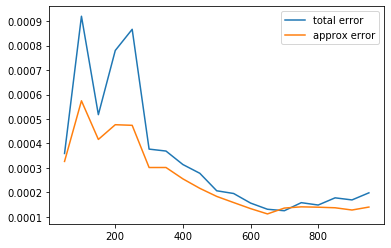

In [10]:
eapp_toplt = eapp[50:1000:50]
diff = [etot[i] - eapp_toplt[i] for i in range(len(etot))]
plt.plot(range(50,1000,50),etot,label = 'total error')
plt.plot(range(50,1000,50),eapp_toplt, label = 'approx error')
plt.legend(loc='best')

In [ ]:
def dist(x,y):
    return sum([(x[i]-y[i])**2 for i in range(len(x))])

In [28]:
K = 1000
step = 5
def prepare_plot_data(K = 1000,step = 5):
    uqsa = UQSA_generator(n_iter=2,K=K,plot=False)
    u = uqsa.run_out([0.3,0.4,0.5])
    
    eapp = []
    u = uqsa.u_theory_result
    u_record = uqsa.u_record
    for u_t in u_record:
        eapp.append(sum([dist(u_t[i],u[i]) for i in range(len(u_t))]))
    # plt.plot(range(len(eapp)),eapp)  
    # plt.title("error approximation")

    rhos = np.random.rand(100) * 0.2 + 0.3
    etot = []
    w = uqsa.omega_theory
    for i in range(step,K,step):
        temp = 0.0
        for rho in rhos:
            w_UQSA = list(uqsa.W(len(u_record[i])-1,rho,u_record[i]))
            s = sum(w_UQSA)
            w_UQSA.append(1.0-s)
    #         print((w_UQSA))

            temp += (dist(w(rho),w_UQSA))
        etot.append(temp/500)

    eapp_toplt = eapp[step:K:step]
    # diff = [etot[i] - eapp_toplt[i] for i in range(len(etot))]
    # plt.plot(range(50,1000,50),etot,label = 'total error')
    # plt.plot(range(50,1000,50),eapp_toplt, label = 'approx error')
    # plt.legend(loc='best')
    return etot,eapp_toplt

In [18]:
etot,eapp = prepare_plot_data(K,step)

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.53it/s]


In [32]:
EAPP = []
ETOT = []
K = 10000
step = 20
for i in range(10):
    etot,eapp = prepare_plot_data(K,step)
    EAPP.append(eapp)
    ETOT.append(etot)
    

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:20<00:00, 71.23it/s]


In [33]:
ETOT = np.mean(np.array(ETOT),axis = 0)
EAPP = np.mean(np.array(EAPP),axis = 0)

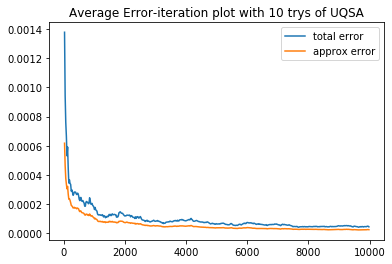

In [34]:
plt.plot(range(step,K,step),ETOT,label = 'total error')
plt.plot(range(step,K,step),EAPP, label = 'approx error')
plt.legend(loc='best')
plt.title("Average Error-iteration plot with 10 trys of UQSA")
plt.show()

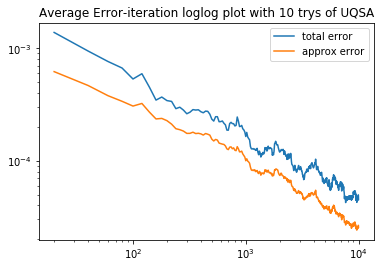

In [35]:
plt.loglog(range(step,K,step),ETOT,label = 'total error')
plt.loglog(range(step,K,step),EAPP, label = 'approx error')
plt.legend(loc='best')
plt.title("Average Error-iteration loglog plot with 10 trys of UQSA")
plt.show()

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:14<00:00, 74.37it/s]


the u in the end of the iteration is : 
[[ 3.29669489e-01  3.72730907e-02]
 [ 2.05302877e-02 -2.71939914e-02]
 [ 3.37829920e-03 -3.22341810e-03]
 [-1.08939908e-03 -3.58865898e-04]
 [ 1.18890437e-03 -1.56042866e-03]
 [ 6.61169606e-04 -1.14531806e-03]
 [ 5.42884440e-06  3.44270894e-04]
 [ 6.53020711e-04 -1.67272250e-05]
 [-1.43376999e-03 -4.24205666e-04]
 [ 7.41425550e-04 -3.49824319e-04]
 [ 2.21232832e-04  5.23113440e-04]]
------------------------------------------------------------
and the result of rho = 0.3 is 
 [0.660268618260364, 0.18047872443205837, 0.15925265730757765]
compare with the theory result : 
 [[0.67654597 0.17242183 0.1510322 ]]

------------------------------------------------------------
and the result of rho = 0.4 is 
 [0.7275223671001776, 0.0842224067868908, 0.18825522611293155]
compare with the theory result : 
 [[0.73492551 0.09458501 0.17048948]]

------------------------------------------------------------
and the result of rho = 0.5 is 
 [0.841976024868952, -0

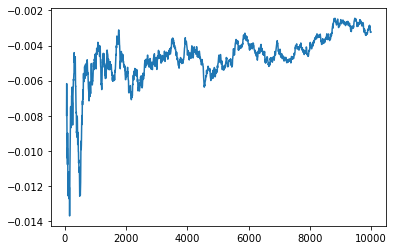

In [31]:
uqsa = UQSA_generator(n=2,K=10000)
u = uqsa.run_out([0.3,0.4,0.5,0.8])

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.05it/s]


the u in the end of the iteration is : 
[[ 3.34629837e-01  3.43416765e-02]
 [ 1.48961195e-02 -2.60689378e-02]
 [ 1.40131054e-03 -1.55831797e-03]
 [-1.92949724e-04 -1.43564930e-03]
 [ 3.00567160e-03 -4.92281623e-03]
 [-1.99255044e-03  1.12829394e-04]
 [ 3.97330090e-05  1.60365780e-03]]
------------------------------------------------------------
and the result of rho = 0.3 is 
 [0.7339708444466083, 0.15752579300967548, 0.10850336254371618]
compare with the theory result : 
 [[0.67654597 0.17242183 0.1510322 ]]

------------------------------------------------------------
and the result of rho = 0.4 is 
 [0.7522126779356925, 0.064262052706563, 0.1835252693577445]
compare with the theory result : 
 [[0.73492551 0.09458501 0.17048948]]

------------------------------------------------------------
and the result of rho = 0.5 is 
 [0.8175183786430967, -0.05971663209873325, 0.2421982534556365]
compare with the theory result : 
 [[ 0.82688391 -0.0407332   0.21384929]]

------------------------

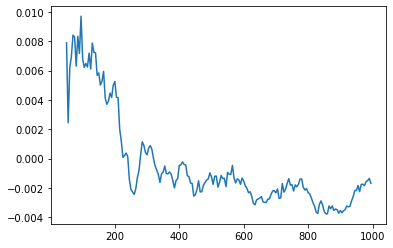

In [7]:
uqsa = UQSA_generator(n_iter=2,K=1000)
u = uqsa.run_out([0.3,0.4,0.5,0.8])

In [13]:
x = np.random.randn(2,3)

In [15]:
np.random.randn(np.shape(x)[0],np.shape(x)[1])

array([[-0.07670304,  0.76921081, -0.74277723],
       [ 1.60805119, -0.65427796,  1.39969144]])

#### Explication of Error:

by defination of inner product, $\langle f,g\rangle := \int f(\theta)g(\theta) \pi(d\theta)$ our basis $B_i(\theta)$ is orthognal and normalized. i.e. 
$\langle B_i,B_j \rangle_{\pi} = \delta_{ij} \tag{*}$

Hence when we simulate $\epsilon^{tot} = \sum_{i=1}^{\infty}{\|u_i - u_i^{UQSA}\|}^2$ we can dirrectly use the $\omega(\theta) - \omega^{UQSA}(\theta)$ with the help of orthogonality. To make it more clear:
$$
\begin{aligned}
\epsilon^{tot} 
& = {\|\omega - \omega^{UQSA}\|}^2_{\pi} = \langle \omega - \omega^{UQSA},\omega - \omega^{UQSA} \rangle_{\pi}, \quad where, \omega - \omega^{UQSA} = \sum_{i=1}^{\infty}(u_i - u_i^{UQSA})B_i \\
(since \quad (*)) \quad& = \sum_{i=1}^{\infty}{\|u_i - u_i^{UQSA}\|}^2 \\
(LGN) \quad& = \lim_{M\to\infty} \frac{1}{M} \sum_{i = 1}^M {\|\omega(\theta_i) - \omega^{UQSA}(\theta_i)\|}^2 \quad \text{,with } \theta_i \text{ iid}
\end{aligned}$$

In [63]:
np.random.rand(10)*0.3 + 0.1

array([0.1078729 , 0.33663571, 0.22389418, 0.15773459, 0.2841125 ,
       0.20808435, 0.24157169, 0.22199989, 0.371625  , 0.22751207])